In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
#import talib

# Load the dataset
file_path = "./data/AA_2010_05.csv"  # Update with your file path if needed
df = pd.read_csv(file_path)
df["xltime"] = pd.to_datetime(df["xltime"], format="ISO8601", errors="coerce")
display(df)


,Unnamed: 0,xltime,trade-price,trade-volume,bid-price,bid-volume,ask-price,ask-volume
0,0,2010-05-03 10:51:36.194000-04:00,13.47,500.0,13.380000,18,13.470000,5
1,1,2010-05-03 12:00:54.482000-04:00,13.47,1000.0,13.470000,8,13.500000,4
2,2,2010-05-03 12:06:58.480000-04:00,13.50,1000.0,13.470000,116,13.500000,47
3,3,2010-05-03 12:08:58.342000-04:00,13.50,1300.0,13.470000,23,13.500000,5
4,4,2010-05-03 12:19:50.406000-04:00,13.50,100.0,13.496667,99,13.500000,17
...,...,...,...,...,...,...,...,...
327781,327781,2010-05-28 22:19:06.177000-04:00,11.66,550.0,11.650000,20,11.720000,21
327782,327782,2010-05-28 22:23:38.293000-04:00,11.64,500.0,11.635000,3,11.700000,4
327783,327783,2010-05-28 22:47:55.403000-04:00,11.63,100.0,11.600000,2,11.700000,3
327784,327784,2010-05-28 23:46:02.480000-04:00,11.66,300.0,11.660000,15,11.700000,6


In [2]:
# Check result
print(df.dtypes)
df.head()

Unnamed: 0                          int64
xltime          datetime64[ns, UTC-04:00]
trade-price                       float64
trade-volume                      float64
bid-price                         float64
bid-volume                          int64
ask-price                         float64
ask-volume                          int64
dtype: object


,Unnamed: 0,xltime,trade-price,trade-volume,bid-price,bid-volume,ask-price,ask-volume
0,0,2010-05-03 10:51:36.194000-04:00,13.47,500.0,13.380000,18,13.47,5
1,1,2010-05-03 12:00:54.482000-04:00,13.47,1000.0,13.470000,8,13.50,4
2,2,2010-05-03 12:06:58.480000-04:00,13.50,1000.0,13.470000,116,13.50,47
3,3,2010-05-03 12:08:58.342000-04:00,13.50,1300.0,13.470000,23,13.50,5
4,4,2010-05-03 12:19:50.406000-04:00,13.50,100.0,13.496667,99,13.50,17


In [41]:
import polars as pl

def volatility_spike(file_path, window=20, volatility_threshold=2, price_change_threshold=1, holding_period=50, spread_threshold=0.001):
    """
    Improved Volatility-based trading strategy.

    Parameters:
    - file_path (str): Path to the CSV file.
    - window (int): Rolling window size for volatility calculation.
    - volatility_threshold (float): Multiplier for detecting a volatility spike.
    - price_change_threshold (float): Minimum price change (%) to enter trade.
    - holding_period (int): Number of ticks to hold the trade.
    - spread_threshold (float): Max allowed bid-ask spread to execute a trade.

    Returns:
    - float: Total return for the month.
    """

    # Load dataset
    df = pl.read_csv(file_path)

    # Convert timestamp
    df = df.with_columns(pl.col("xltime").str.to_datetime().alias("xltime"))

    # Select relevant columns
    df = df.select(["xltime", "trade-price", "trade-volume", "bid-price", "bid-volume", "ask-price", "ask-volume"])

    # Compute rolling standard deviation (volatility)
    df = df.with_columns([df["trade-price"].rolling_std(window).alias("Rolling_Volatility")])

    # Compute long-term average volatility
    df = df.with_columns([df["Rolling_Volatility"].rolling_mean(window * 5).alias("Avg_Volatility")])

    # Compute absolute price movement over the window
    df = df.with_columns([((df["trade-price"] - df["trade-price"].shift(window)) / df["trade-price"].shift(window) * 100).alias("Price_Change")])

    # Identify volatility spikes with strong price movement
    df = df.with_columns(((df["Rolling_Volatility"] > df["Avg_Volatility"] * volatility_threshold) & (df["Price_Change"].abs() > price_change_threshold)).alias("Volatility_Spike"))

    # Filter based on bid-ask spread condition
    df = df.with_columns(((df["ask-price"] - df["bid-price"]) / df["bid-price"] < spread_threshold).alias("Valid_Spread"))

    # Final Trade Execution Signal (only when both conditions are met)
    df = df.with_columns((df["Volatility_Spike"] & df["Valid_Spread"]).alias("Execute_Trade"))

    # Buy at Ask Price
    df = df.with_columns(df["ask-price"].alias("Entry_Price"))

    # Sell at Bid Price after holding period
    df = df.with_columns(df["bid-price"].shift(-holding_period).alias("Exit_Price"))

    # Compute trade returns
    df = df.with_columns(((df["Exit_Price"] - df["Entry_Price"]) / df["Entry_Price"]).alias("Trade_Return"))

    # Keep only executed trades and sum returns
    total_return = df.filter(df["Execute_Trade"]).select(pl.sum("Trade_Return")).item()

    return total_return


In [74]:
file_path = "./data/TEN_2010_05.csv"
total_return = volatility_spike(file_path, window=18, volatility_threshold=2, price_change_threshold=1, holding_period=50, spread_threshold=0.001)

print(f"Total Return for the Day: {total_return:.4f}")


Total Return for the Day: -0.4808


In [36]:
import os
import glob

def collect_stocks_and_dates(data_folder):
    """
    Lit tous les fichiers CSV dans le dossier, extrait les noms des stocks et les mois/années.

    Parameters:
    - data_folder (str): Chemin du dossier contenant les fichiers CSV.

    Returns:
    - stocks (list): Liste des noms de stocks uniques.
    - months_years (list): Liste des mois/années uniques.
    """

    # Trouver tous les fichiers CSV
    csv_files = glob.glob(os.path.join(data_folder, "*.csv"))

    # Initialiser les listes pour stocker les résultats
    stocks = []
    months_years = []

    for file_path in csv_files:
        # Extraire le nom du fichier sans extension
        filename = os.path.basename(file_path).replace(".csv", "")

        # Séparer le nom du stock et la date
        parts = filename.split("_")
        
        if len(parts) == 3:
            stock_name = parts[0]  # Nom de l'action
            date_part = parts[1] +"_"+ parts[2]   # Mois/Année
            
            # Ajouter aux listes si non déjà présent
            if stock_name not in stocks:
                stocks.append(stock_name)
            if date_part not in months_years:
                months_years.append(date_part)
        else:
            print(f"Fichier ignoré (format non conforme) : {filename}")

    return stocks, months_years

# Chemin du dossier contenant les fichiers CSV
data_folder = "./data/"

# Exécuter la fonction
stocks_list, months_years_list = collect_stocks_and_dates(data_folder)

# Afficher les résultats
print("📌 Liste des stocks :", stocks_list)
print("📆 Liste des mois/années :", months_years_list)


📌 Liste des stocks : ['MRO', 'MWW', 'WRB', 'IP', 'SLG', 'BKR', 'AA', 'MOT', 'UNH', 'CSC', 'HRB', 'CHD', 'TFX', 'PNR', 'TEN', 'AFL', 'GPS', 'EXC', 'DOV', 'SYY']
📆 Liste des mois/années : ['2010_05']



📊 Volatility Spike Strategy Results:
Stock Month_Year  Window  Vol_Threshold  Price_Threshold  Holding_Period  Spread_Threshold  Total Return
   IP    2010_05      30            2.5              0.5             100            0.0020      1.365401
   IP    2010_05      30            1.5              1.5             100            0.0020      1.296800
   IP    2010_05      30            2.5              1.0             100            0.0020      1.278726
   IP    2010_05      30            1.5              1.5             100            0.0010      1.262276
   IP    2010_05      30            2.0              1.5             100            0.0020      1.238934
   IP    2010_05      30            2.5              1.5             100            0.0020      1.230432
   IP    2010_05      30            2.5              0.5             100            0.0010      1.229503
   IP    2010_05      20            2.0              1.0             100            0.0020      1.214835
   IP    2010_05 

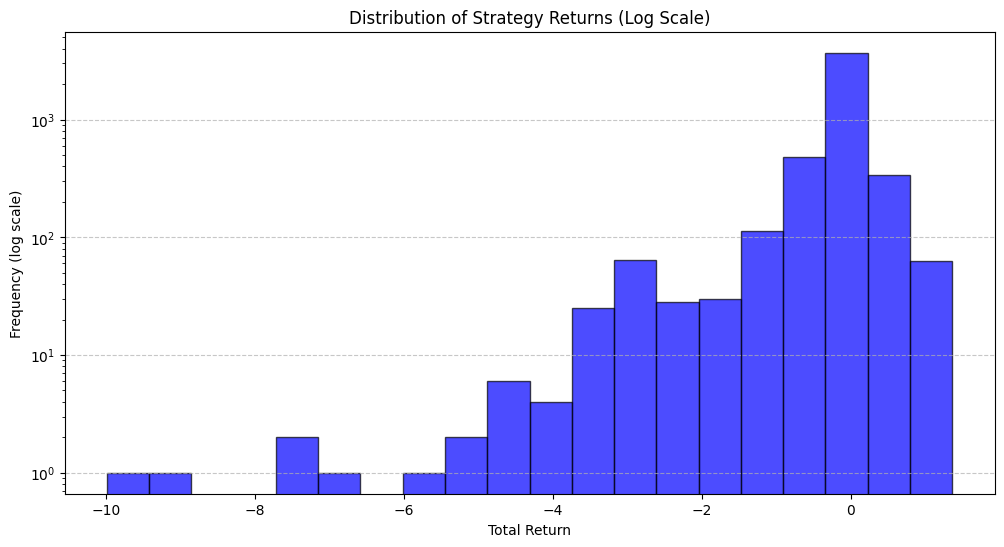

In [40]:
import os
import glob
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def process_stocks_with_strategy(data_folder, strategy_func, param_grid):
    """
    Applies the strategy to all stocks in the dataset with different parameter combinations.

    Parameters:
    - data_folder (str): Folder containing CSV files.
    - strategy_func (function): Strategy function (e.g., volatility_spike).
    - param_grid (dict): Dictionary of parameter ranges to test.

    Returns:
    - DataFrame with sorted results.
    - Generates a histogram of total returns in log scale.
    """

    # Collect stocks and periods
    stocks_list, months_years_list = collect_stocks_and_dates(data_folder)

    # Store results
    results = []

    for stock in stocks_list:
        for month_year in months_years_list:
            file_path = os.path.join(data_folder, f"{stock}_{month_year}.csv")
            if not os.path.exists(file_path):
                continue  # Skip missing files

            # Test all parameter combinations
            for window in param_grid["window"]:
                for vol_thresh in param_grid["volatility_threshold"]:
                    for price_thresh in param_grid["price_change_threshold"]:
                        for hold_period in param_grid["holding_period"]:
                            for spread_thresh in param_grid["spread_threshold"]:
                                
                                # Run strategy
                                total_return = strategy_func(
                                    file_path, 
                                    window=window,
                                    volatility_threshold=vol_thresh,
                                    price_change_threshold=price_thresh,
                                    holding_period=hold_period,
                                    spread_threshold=spread_thresh
                                )

                                # Store the result
                                results.append({
                                    "Stock": stock,
                                    "Month_Year": month_year,
                                    "Window": window,
                                    "Vol_Threshold": vol_thresh,
                                    "Price_Threshold": price_thresh,
                                    "Holding_Period": hold_period,
                                    "Spread_Threshold": spread_thresh,
                                    "Total Return": total_return
                                })

    # Convert to DataFrame
    df_results = pd.DataFrame(results)

    # Sort by performance
    df_results = df_results.sort_values(by="Total Return", ascending=False)

    # Display results
    print("\n📊 Volatility Spike Strategy Results:")
    print(df_results.to_string(index=False))

    # 📈 Plot histogram with log scale
    plt.figure(figsize=(12, 6))
    plt.hist(df_results["Total Return"], bins=20, color='blue', edgecolor='black', alpha=0.7)
    plt.yscale("log")  # Log scale for better visualization
    plt.xlabel("Total Return")
    plt.ylabel("Frequency (log scale)")
    plt.title("Distribution of Strategy Returns (Log Scale)")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    return df_results

# Define the parameter ranges to test
param_grid = {
    "window": [10, 20, 30],
    "volatility_threshold": [1.5, 2, 2.5],
    "price_change_threshold": [0.5, 1, 1.5],
    "holding_period": [20, 50, 100],
    "spread_threshold": [0.0005, 0.001, 0.002]
}

# Run the function on all stocks
data_folder = "./data/"
df_results = process_stocks_with_strategy(data_folder, volatility_spike, param_grid)
